In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import joblib
from statsmodels.tsa.seasonal import seasonal_decompose


In [2]:
sales_data = pd.read_csv("../data/raw/raw_data.csv")

sales_data.drop("Unnamed: 0", axis=1, inplace=True)

# Convert the 'date' column to datetime
sales_data['date'] = pd.to_datetime(sales_data['date'])

# Set the 'date' column as the index
sales_data.set_index('date', inplace=True)

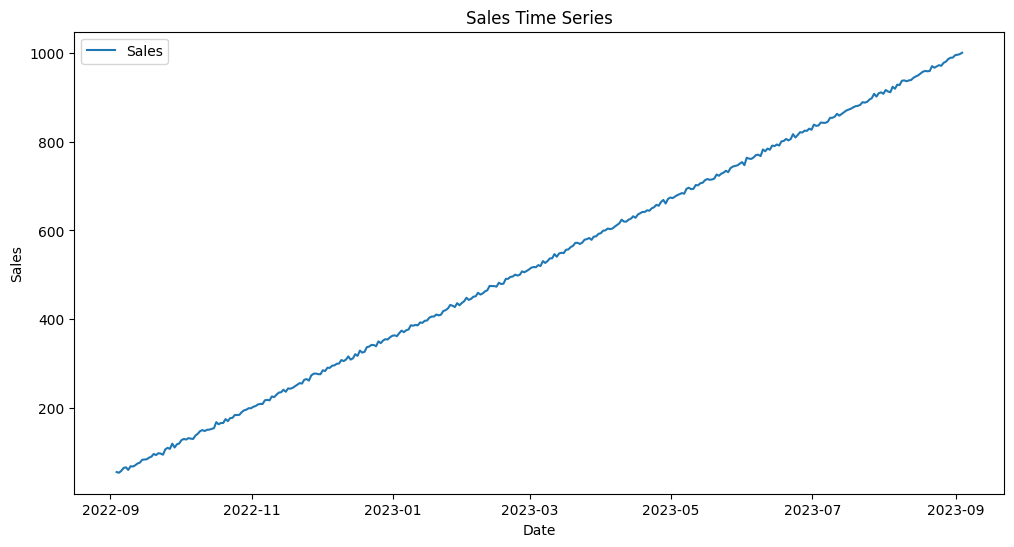

In [3]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(sales_data['sales'], label='Sales')
plt.title('Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [4]:
# Check the frequency of the dataset
print(f"Frequency of the dataset: {sales_data.index.freq}")

# Perform ADF test to check for stationarity
result = adfuller(sales_data['sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Make the series stationary if necessary
if result[1] > 0.05:
    sales_data['sales_diff'] = sales_data['sales'].diff().dropna()
else:
    sales_data['sales_diff'] = sales_data['sales']

Frequency of the dataset: None
ADF Statistic: 0.5454141937063706
p-value: 0.9861899815311063


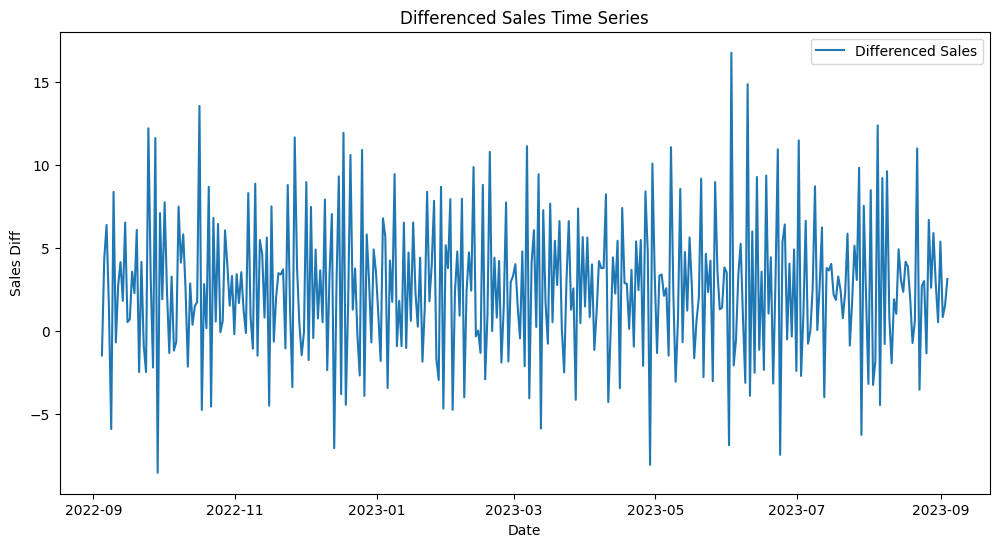

In [5]:
# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(sales_data['sales_diff'], label='Differenced Sales')
plt.title('Differenced Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales Diff')
plt.legend()
plt.show()


In [6]:
# Step 3: Train an ARIMA model

# Split the data into training and test sets
train_size = int(len(sales_data) * 0.8)
train, test = sales_data['sales_diff'][:train_size], sales_data['sales_diff'][train_size:]

# Find the best parameterization of ARIMA
model = auto_arima(train.dropna(), seasonal=True, m=12, trace=True)  # Assuming monthly seasonality
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1483.236, Time=1.05 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1675.428, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1579.885, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1477.111, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1763.761, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1475.165, Time=0.10 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1477.106, Time=0.34 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1478.876, Time=0.79 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1475.512, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=1475.495, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1578.564, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=1479.028, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=1762.924, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 3.128 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  291
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -734.583
Date:                Mon, 05 Aug 2024   AIC                           1475.165
Time:                        20:54:03   BIC                           1486.185
Sample:                    09-04-2022   HQIC                          1479.580
                         - 06-21-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5984      0.011    243.639      0.000       2.577       2.619
ma.L1         -0.9439      0.021    -44.117      0.000      -0.986      -0.902
sigma2         9.0537      0.817     11.084      0.000       7.453      10.655
===================================================================================
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.25   Prob(JB):                         0.54
Heteroskedasticity (H):               0.95   Skew:                             0.06
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
# Train the ARIMA model with the best parameters
arima_model = ARIMA(train.dropna(), order=model.order, seasonal_order=model.seasonal_order)
arima_model_fit = arima_model.fit()
arima_model_fit.summary()


d:\Programs\Anaconda\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Programs\Anaconda\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Programs\Anaconda\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             sales_diff   No. Observations:                  291
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -734.583
Date:                Mon, 05 Aug 2024   AIC                           1475.165
Time:                        20:54:04   BIC                           1486.185
Sample:                    09-04-2022   HQIC                          1479.580
                         - 06-21-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5984      0.011    243.647      0.000       2.577       2.619
ma.L1         -0.9439      0.021    -44.118      0.000      -0.986      -0.902
sigma2         9.0537      0.817     11.084      0.000       7.453      10.655
===================================================================================
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.25   Prob(JB):                         0.54
Heteroskedasticity (H):               0.95   Skew:                             0.06
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

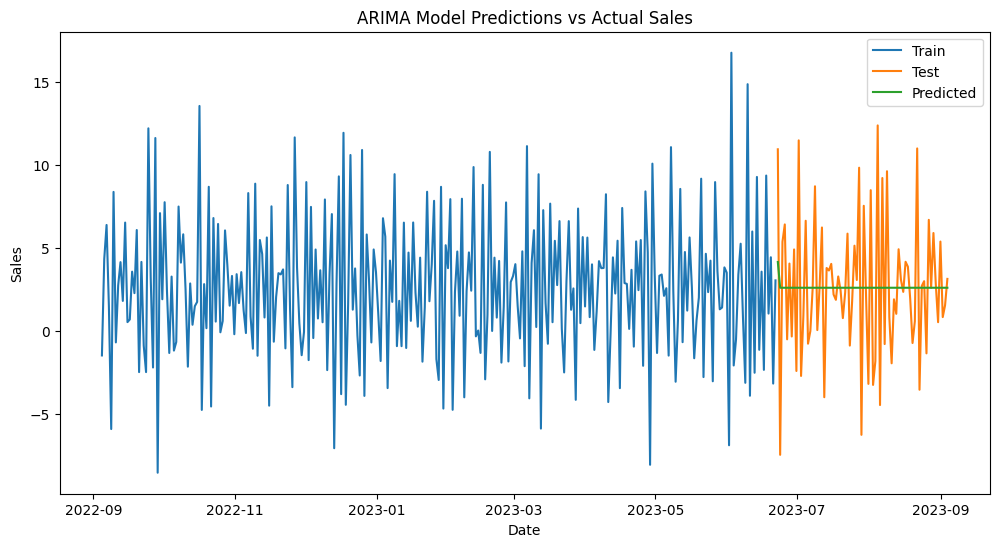

Mean Squared Error: 16.99743726020724


In [8]:
# Step 4: Predict with the test set

# Make predictions
predictions = arima_model_fit.forecast(steps=len(test))
predictions = pd.Series(predictions, index=test.index)

# Plot predictions vs actual sales
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('ARIMA Model Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Measure performance using Mean Squared Error
mse = mean_squared_error(test, predictions)
print('Mean Squared Error:', mse)

In [ ]:
# Step 5: Save the model

# Save the ARIMA model
joblib.dump(arima_model_fit, '../models/arima_model.pkl')

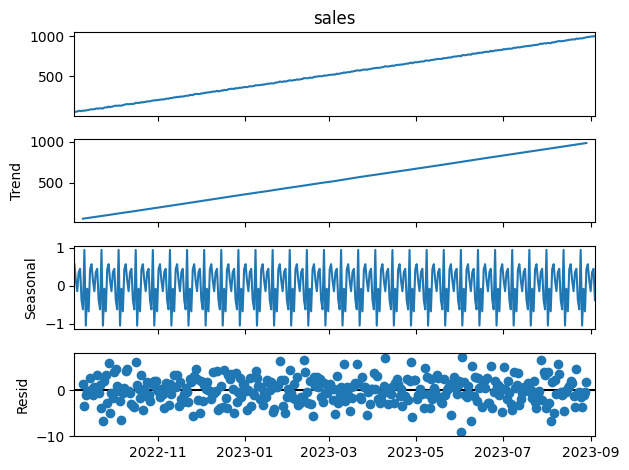

In [12]:
# Step 6: Check for seasonality using seasonal decomposition
decomposition = seasonal_decompose(sales_data['sales'], model='additive', period=12)
decomposition.plot()
plt.show()

In [13]:
# Step 7: Train a seasonal ARIMA model

# Split the data into training and test sets
train_size = int(len(sales_data) * 0.8)
train, test = sales_data['sales_diff'][:train_size], sales_data['sales_diff'][train_size:]

# Find the best parameterization of ARIMA
model = auto_arima(train.dropna(), seasonal=True, m=12, trace=True)  # Adjusting for seasonality
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1483.236, Time=1.02 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1675.428, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1579.885, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1477.111, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1763.761, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1475.165, Time=0.08 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1477.106, Time=0.35 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1478.876, Time=0.80 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1475.512, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=1475.495, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1578.564, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=1479.028, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=1762.924, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 3.099 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  291
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -734.583
Date:                Mon, 05 Aug 2024   AIC                           1475.165
Time:                        20:56:21   BIC                           1486.185
Sample:                    09-04-2022   HQIC                          1479.580
                         - 06-21-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5984      0.011    243.639      0.000       2.577       2.619
ma.L1         -0.9439      0.021    -44.117      0.000      -0.986      -0.902
sigma2         9.0537      0.817     11.084      0.000       7.453      10.655
===================================================================================
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.25   Prob(JB):                         0.54
Heteroskedasticity (H):               0.95   Skew:                             0.06
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
# Train the ARIMA model with the best parameters
arima_model = ARIMA(train.dropna(), order=model.order, seasonal_order=model.seasonal_order)
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

d:\Programs\Anaconda\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Programs\Anaconda\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Programs\Anaconda\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             sales_diff   No. Observations:                  291
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -734.583
Date:                Mon, 05 Aug 2024   AIC                           1475.165
Time:                        20:56:24   BIC                           1486.185
Sample:                    09-04-2022   HQIC                          1479.580
                         - 06-21-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5984      0.011    243.647      0.000       2.577       2.619
ma.L1         -0.9439      0.021    -44.118      0.000      -0.986      -0.902
sigma2         9.0537      0.817     11.084      0.000       7.453      10.655
===================================================================================
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.25   Prob(JB):                         0.54
Heteroskedasticity (H):               0.95   Skew:                             0.06
Prob(H) (two-sided):                  0.81   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

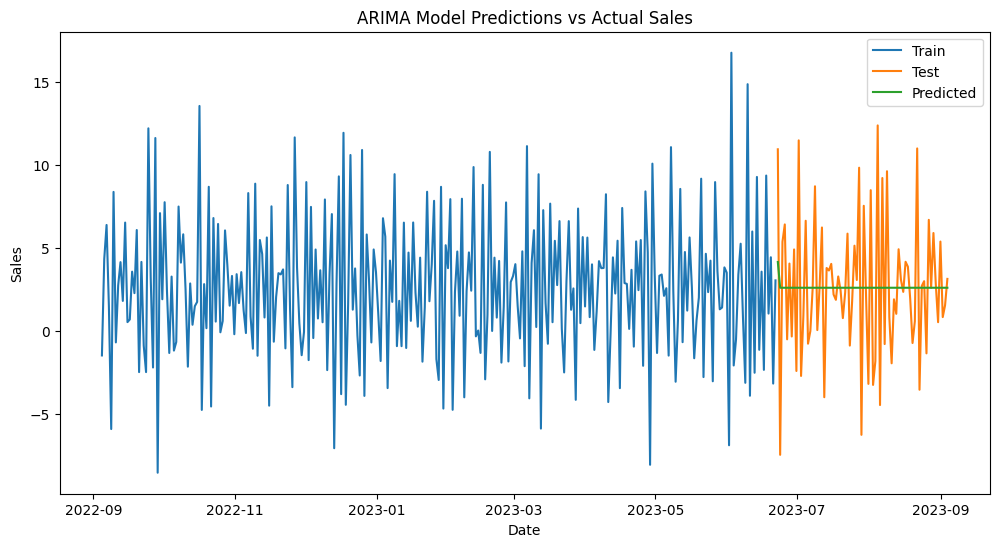

Mean Squared Error: 16.99743726020724


In [15]:
# Step 8: Predict with the test set

# Make predictions
predictions = arima_model_fit.forecast(steps=len(test))
predictions = pd.Series(predictions, index=test.index)

# Plot predictions vs actual sales
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('ARIMA Model Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Measure performance using Mean Squared Error
mse = mean_squared_error(test, predictions)
print('Mean Squared Error:', mse)


In [16]:
# Step 9: Save the model

# Save the ARIMA model
joblib.dump(arima_model_fit, '../models/sarima_model.pkl')


['../models/sarima_model.pkl']